In [3]:
import os
import pandas as pd
import numpy as np

# Load all CSV files
os.chdir("C:\\Users\\kusha\\OneDrive\\Desktop\\Kushang's Files\\Intel AI Course\\Week 4 - Dependencies\\Dependencies\\data")

# Load data
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')

### ✅ 1. Handle Missing Values
# Drop rows with critical missing values in customer_id (as it's a key field)
customers.dropna(subset=['customer_id'], inplace=True)

# Fill missing values in geolocation dataset (using median for numerical columns)
geolocation['geolocation_lat'] = geolocation['geolocation_lat'].fillna(geolocation['geolocation_lat'].median())
geolocation['geolocation_lng'] = geolocation['geolocation_lng'].fillna(geolocation['geolocation_lng'].median())

# Fill missing product category names using most common category
products['product_category_name'] = products['product_category_name'].fillna(products['product_category_name'].mode()[0])

# Fill missing order review scores with median
order_reviews['review_score'] = order_reviews['review_score'].fillna(order_reviews['review_score'].median())

### ✅ 2. Remove Duplicates
customers.drop_duplicates(inplace=True)
geolocation.drop_duplicates(inplace=True)
order_items.drop_duplicates(inplace=True)
order_payments.drop_duplicates(inplace=True)
order_reviews.drop_duplicates(inplace=True)
orders.drop_duplicates(inplace=True)
products.drop_duplicates(inplace=True)
sellers.drop_duplicates(inplace=True)
category_translation.drop_duplicates(inplace=True)

### ✅ 3. Format Data Types
# Convert date columns to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

# Ensure numeric columns are of float type where applicable
geolocation['geolocation_lat'] = geolocation['geolocation_lat'].astype(float)
geolocation['geolocation_lng'] = geolocation['geolocation_lng'].astype(float)
order_reviews['review_score'] = order_reviews['review_score'].astype(float)

### ✅ 4. Handle Outliers (Using IQR method)
# Function to handle outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Handle outliers in order payments (payment value)
order_payments = remove_outliers(order_payments, 'payment_value')

# Handle outliers in order review scores
order_reviews = remove_outliers(order_reviews, 'review_score')

# Handle outliers in geolocation data
geolocation = remove_outliers(geolocation, 'geolocation_lat')
geolocation = remove_outliers(geolocation, 'geolocation_lng')

### ✅ 5. Save Cleaned Data (Optional)
customers.to_csv('cleaned_olist_customers_dataset.csv', index=False)
geolocation.to_csv('cleaned_olist_geolocation_dataset.csv', index=False)
order_items.to_csv('cleaned_olist_order_items_dataset.csv', index=False)
order_payments.to_csv('cleaned_olist_order_payments_dataset.csv', index=False)
order_reviews.to_csv('cleaned_olist_order_reviews_dataset.csv', index=False)
orders.to_csv('cleaned_olist_orders_dataset.csv', index=False)
products.to_csv('cleaned_olist_products_dataset.csv', index=False)
sellers.to_csv('cleaned_olist_sellers_dataset.csv', index=False)
category_translation.to_csv('cleaned_product_category_name_translation.csv', index=False)

print("✅ Data cleaning completed successfully!")


✅ Data cleaning completed successfully!


In [4]:
import pandas as pd
import numpy as np

# Load cleaned data
customers = pd.read_csv('cleaned_olist_customers_dataset.csv')
geolocation = pd.read_csv('cleaned_olist_geolocation_dataset.csv')
order_items = pd.read_csv('cleaned_olist_order_items_dataset.csv')
order_payments = pd.read_csv('cleaned_olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('cleaned_olist_order_reviews_dataset.csv')
orders = pd.read_csv('cleaned_olist_orders_dataset.csv')
products = pd.read_csv('cleaned_olist_products_dataset.csv')
sellers = pd.read_csv('cleaned_olist_sellers_dataset.csv')
category_translation = pd.read_csv('cleaned_product_category_name_translation.csv')

### ✅ 1. Create Delivery Time Feature
# Calculate delivery time in days
orders['delivery_time'] = (pd.to_datetime(orders['order_delivered_customer_date']) - pd.to_datetime(orders['order_purchase_timestamp'])).dt.days

### ✅ 2. Create Payment Ratio Feature
# Aggregate total payment per order
payment_per_order = order_payments.groupby('order_id')['payment_value'].sum().reset_index()
orders = orders.merge(payment_per_order, on='order_id', how='left')

# Payment per item ratio
order_items_count = order_items.groupby('order_id')['order_item_id'].count().reset_index()
order_items_count.columns = ['order_id', 'item_count']
orders = orders.merge(order_items_count, on='order_id', how='left')

# Create payment ratio feature
orders['payment_ratio'] = orders['payment_value'] / orders['item_count']

### ✅ 3. Create Review Sentiment Feature
# Map review score to sentiment (1-2: negative, 3: neutral, 4-5: positive)
order_reviews['review_sentiment'] = order_reviews['review_score'].map(lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative'))

# Convert sentiment to numeric (positive = 1, neutral = 0, negative = -1)
order_reviews['review_sentiment'] = order_reviews['review_sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

# Merge review sentiment into orders
avg_review_sentiment = order_reviews.groupby('order_id')['review_sentiment'].mean().reset_index()
orders = orders.merge(avg_review_sentiment, on='order_id', how='left')

### ✅ 4. Create Product Price Range Feature
# Calculate price range of products
product_price_range = order_items.groupby('product_id')['price'].agg(['min', 'max']).reset_index()
product_price_range['price_range'] = product_price_range['max'] - product_price_range['min']
products = products.merge(product_price_range[['product_id', 'price_range']], on='product_id', how='left')

### ✅ 5. Create Seller Performance Feature
# Calculate average review score per seller
seller_performance = order_items.merge(order_reviews, on='order_id', how='left').groupby('seller_id')['review_score'].mean().reset_index()
seller_performance.columns = ['seller_id', 'avg_seller_review_score']
sellers = sellers.merge(seller_performance, on='seller_id', how='left')

### ✅ 6. Create Customer Order Frequency Feature
# Calculate total number of orders per customer
customer_order_count = orders.groupby('customer_id').size().reset_index(name='order_count')
customers = customers.merge(customer_order_count, on='customer_id', how='left')

### ✅ 7. Handle Category Translation (Map Portuguese categories to English)
products = products.merge(category_translation, on='product_category_name', how='left')

# Drop the old category name column
products.drop('product_category_name', axis=1, inplace=True)

### ✅ 8. Create Day of the Week and Month Feature
# Extract day of the week and month from order date
orders['order_day_of_week'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.dayofweek
orders['order_month'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.month

### ✅ 9. Save Enhanced Datasets
customers.to_csv('enhanced_olist_customers_dataset.csv', index=False)
geolocation.to_csv('enhanced_olist_geolocation_dataset.csv', index=False)
order_items.to_csv('enhanced_olist_order_items_dataset.csv', index=False)
order_payments.to_csv('enhanced_olist_order_payments_dataset.csv', index=False)
order_reviews.to_csv('enhanced_olist_order_reviews_dataset.csv', index=False)
orders.to_csv('enhanced_olist_orders_dataset.csv', index=False)
products.to_csv('enhanced_olist_products_dataset.csv', index=False)
sellers.to_csv('enhanced_olist_sellers_dataset.csv', index=False)
category_translation.to_csv('enhanced_product_category_name_translation.csv', index=False)

print("✅ Feature engineering completed successfully!")


✅ Feature engineering completed successfully!


In [5]:
import pandas as pd
import numpy as np

# ✅ Load datasets
orders = pd.read_csv('olist_orders_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
product_translation = pd.read_csv('product_category_name_translation.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')

# ✅ Confirm successful loading by printing sample data
print("✅ Orders sample:\n", orders.head(), "\n")
print("✅ Items sample:\n", items.head(), "\n")
print("✅ Reviews sample:\n", reviews.head(), "\n")
print("✅ Products sample:\n", products.head(), "\n")
print("✅ Sellers sample:\n", sellers.head(), "\n")
print("✅ Product Translation sample:\n", product_translation.head(), "\n")
print("✅ Customers sample:\n", customers.head(), "\n")
print("✅ Geolocation sample:\n", geolocation.head(), "\n")
print("✅ Payments sample:\n", payments.head(), "\n")

# ✅ Merge datasets
data = orders.merge(items, on='order_id', how='left')
data = data.merge(payments, on='order_id', how='left')
data = data.merge(reviews[['order_id', 'review_score']], on='order_id', how='left')

print("✅ Merged dataset sample:\n", data.head(), "\n")

# ✅ Clean data: handle missing values
data['review_score'].fillna(data['review_score'].median(), inplace=True)
data['payment_value'].fillna(data['payment_value'].median(), inplace=True)
data.dropna(inplace=True)

print("✅ Cleaned dataset sample:\n", data.head(), "\n")

# ✅ Create new features
data['payment_ratio'] = data['payment_value'] / data['payment_value'].max()
data['review_sentiment'] = data['review_score'].apply(lambda x: 1 if x >= 4 else (0 if x <= 2 else 0.5))

print("✅ Payment Ratio sample:\n", data[['payment_value', 'payment_ratio']].head(), "\n")
print("✅ Review Sentiment sample:\n", data[['review_score', 'review_sentiment']].head(), "\n")

# ✅ Product price range feature
data['price_range'] = pd.cut(data['price'], bins=[0, 50, 150, 300, 500, 1000, np.inf], 
                             labels=['very low', 'low', 'medium', 'high', 'very high', 'luxury'])

print("✅ Price Range sample:\n", data[['price', 'price_range']].head(), "\n")

# ✅ Delivery time feature
data['delivery_time'] = (pd.to_datetime(data['order_delivered_customer_date']) - pd.to_datetime(data['order_purchase_timestamp'])).dt.days

print("✅ Delivery Time sample:\n", data[['order_delivered_customer_date', 'order_purchase_timestamp', 'delivery_time']].head(), "\n")

# ✅ Final dataset shape and summary
print("✅ Final dataset shape:", data.shape, "\n")
print("✅ Final dataset info:\n", data.info(), "\n")

# ✅ Confirm final dataset columns
print("✅ Final dataset columns:\n", data.columns, "\n")


✅ Orders sample:
                            order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00

In [6]:
import pandas as pd
import numpy as np

# Load cleaned data
customers = pd.read_csv('cleaned_olist_customers_dataset.csv')
geolocation = pd.read_csv('cleaned_olist_geolocation_dataset.csv')
order_items = pd.read_csv('cleaned_olist_order_items_dataset.csv')
order_payments = pd.read_csv('cleaned_olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('cleaned_olist_order_reviews_dataset.csv')
orders = pd.read_csv('cleaned_olist_orders_dataset.csv')
products = pd.read_csv('cleaned_olist_products_dataset.csv')
sellers = pd.read_csv('cleaned_olist_sellers_dataset.csv')
category_translation = pd.read_csv('cleaned_product_category_name_translation.csv')

### ✅ 1. Create Delivery Time Feature
# Calculate delivery time in days
orders['delivery_time'] = (pd.to_datetime(orders['order_delivered_customer_date']) - pd.to_datetime(orders['order_purchase_timestamp'])).dt.days

### ✅ 2. Create Payment Ratio Feature
# Aggregate total payment per order
payment_per_order = order_payments.groupby('order_id')['payment_value'].sum().reset_index()
orders = orders.merge(payment_per_order, on='order_id', how='left')

# Payment per item ratio
order_items_count = order_items.groupby('order_id')['order_item_id'].count().reset_index()
order_items_count.columns = ['order_id', 'item_count']
orders = orders.merge(order_items_count, on='order_id', how='left')

# Create payment ratio feature
orders['payment_ratio'] = orders['payment_value'] / orders['item_count']

### ✅ 3. Create Review Sentiment Feature
# Map review score to sentiment (1-2: negative, 3: neutral, 4-5: positive)
order_reviews['review_sentiment'] = order_reviews['review_score'].map(lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative'))

# Convert sentiment to numeric (positive = 1, neutral = 0, negative = -1)
order_reviews['review_sentiment'] = order_reviews['review_sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

# Merge review sentiment into orders
avg_review_sentiment = order_reviews.groupby('order_id')['review_sentiment'].mean().reset_index()
orders = orders.merge(avg_review_sentiment, on='order_id', how='left')

### ✅ 4. Create Product Price Range Feature
# Calculate price range of products
product_price_range = order_items.groupby('product_id')['price'].agg(['min', 'max']).reset_index()
product_price_range['price_range'] = product_price_range['max'] - product_price_range['min']
products = products.merge(product_price_range[['product_id', 'price_range']], on='product_id', how='left')

### ✅ 5. Create Seller Performance Feature
# Calculate average review score per seller
seller_performance = order_items.merge(order_reviews, on='order_id', how='left').groupby('seller_id')['review_score'].mean().reset_index()
seller_performance.columns = ['seller_id', 'avg_seller_review_score']
sellers = sellers.merge(seller_performance, on='seller_id', how='left')

### ✅ 6. Create Customer Order Frequency Feature
# Calculate total number of orders per customer
customer_order_count = orders.groupby('customer_id').size().reset_index(name='order_count')
customers = customers.merge(customer_order_count, on='customer_id', how='left')

### ✅ 7. Handle Category Translation (Map Portuguese categories to English)
products = products.merge(category_translation, on='product_category_name', how='left')

# Drop the old category name column
products.drop('product_category_name', axis=1, inplace=True)

### ✅ 8. Create Day of the Week and Month Feature
# Extract day of the week and month from order date
orders['order_day_of_week'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.dayofweek
orders['order_month'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.month

### ✅ 9. Save Enhanced Datasets
customers.to_csv('enhanced_olist_customers_dataset.csv', index=False)
geolocation.to_csv('enhanced_olist_geolocation_dataset.csv', index=False)
order_items.to_csv('enhanced_olist_order_items_dataset.csv', index=False)
order_payments.to_csv('enhanced_olist_order_payments_dataset.csv', index=False)
order_reviews.to_csv('enhanced_olist_order_reviews_dataset.csv', index=False)
orders.to_csv('enhanced_olist_orders_dataset.csv', index=False)
products.to_csv('enhanced_olist_products_dataset.csv', index=False)
sellers.to_csv('enhanced_olist_sellers_dataset.csv', index=False)
category_translation.to_csv('enhanced_product_category_name_translation.csv', index=False)

print("✅ Feature engineering completed successfully!")


✅ Feature engineering completed successfully!


C:\Users\kusha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


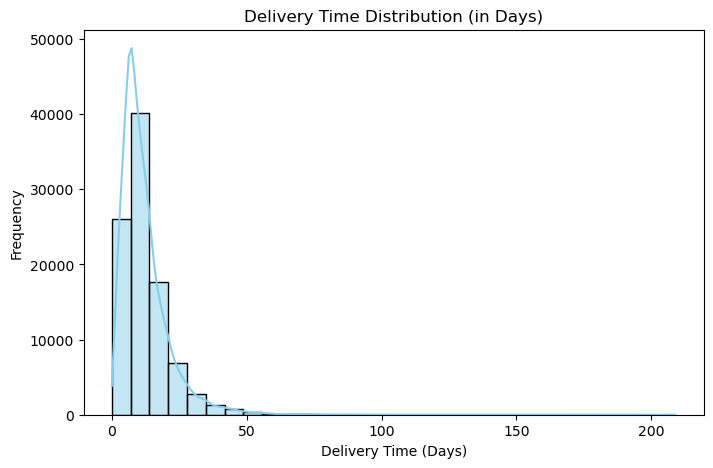

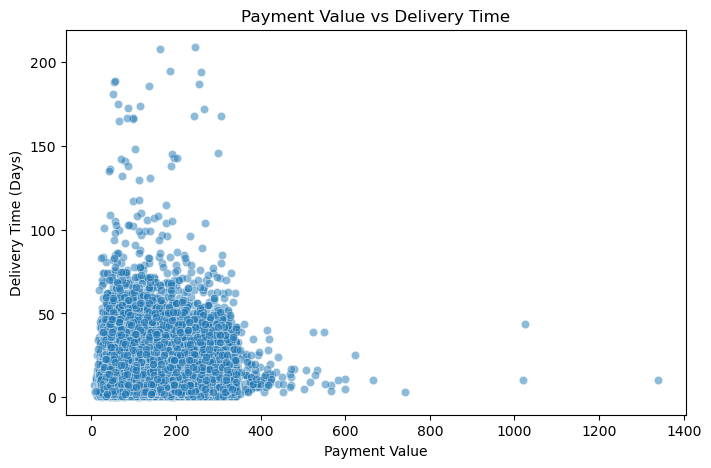

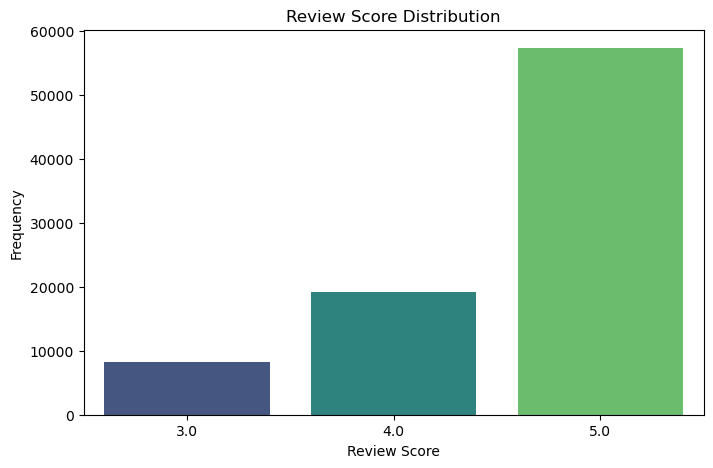

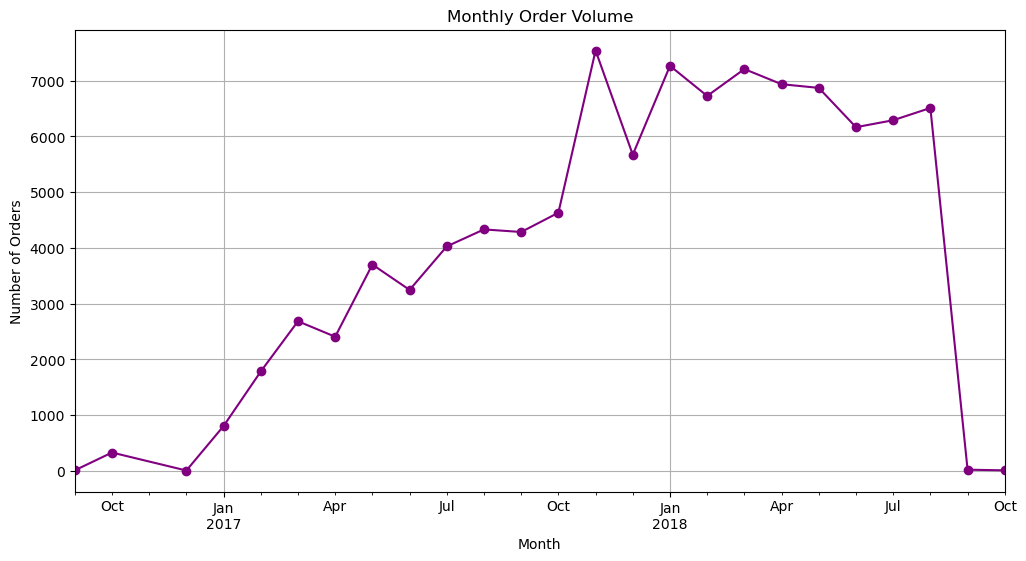

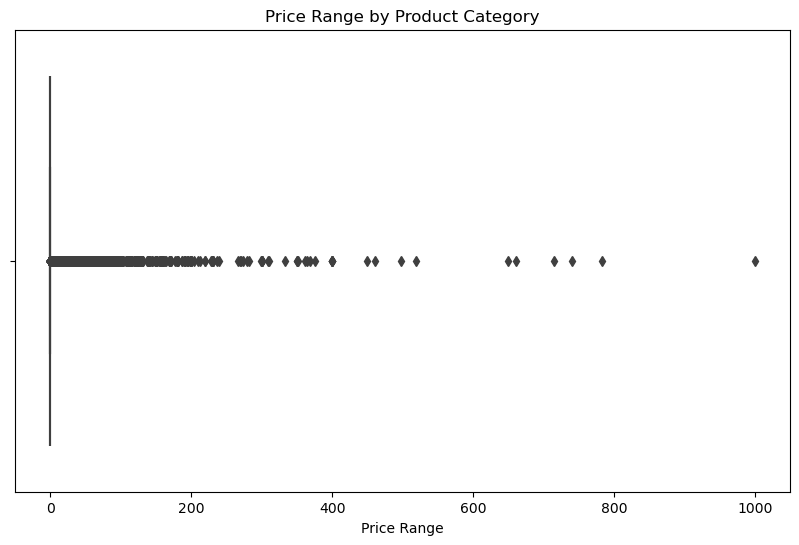

C:\Users\kusha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


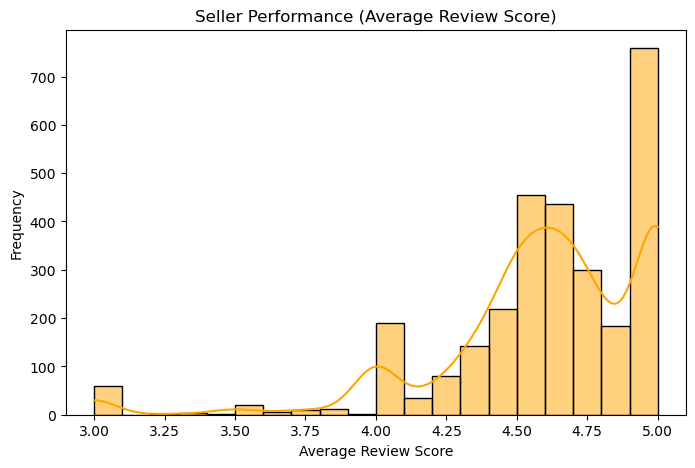

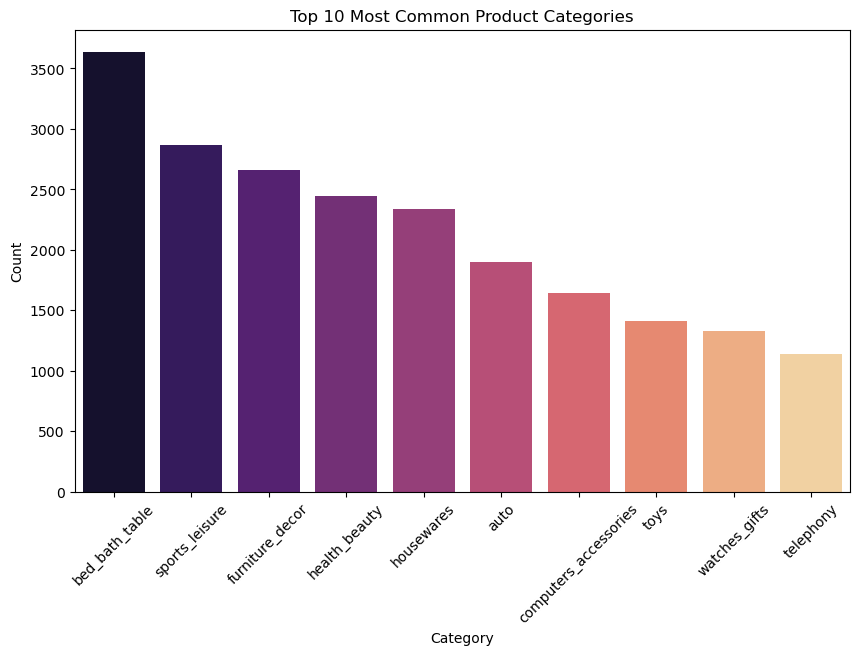

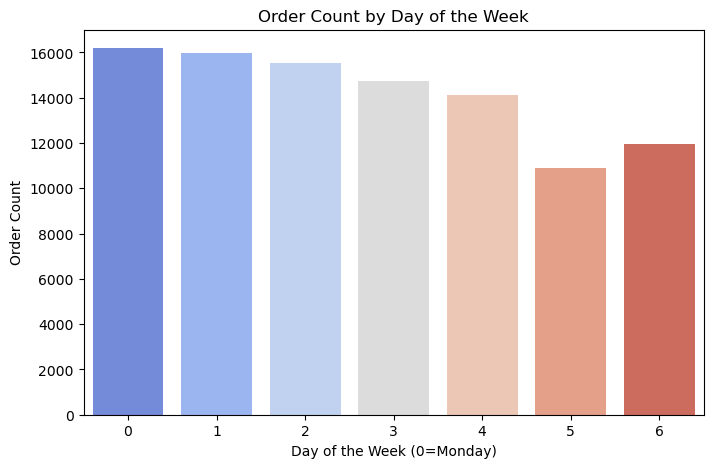

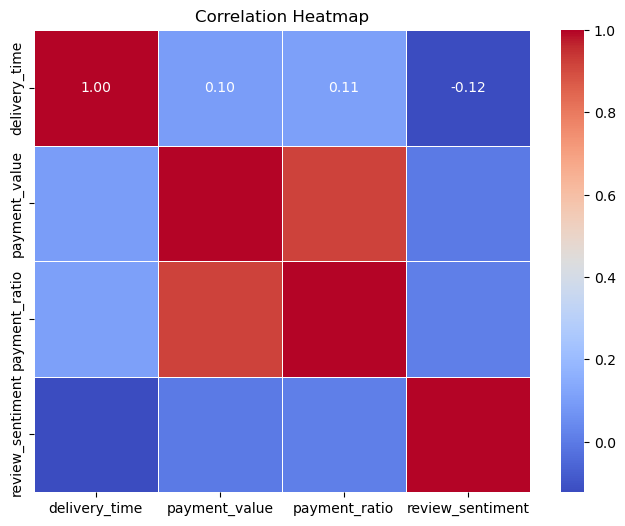

C:\Users\kusha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


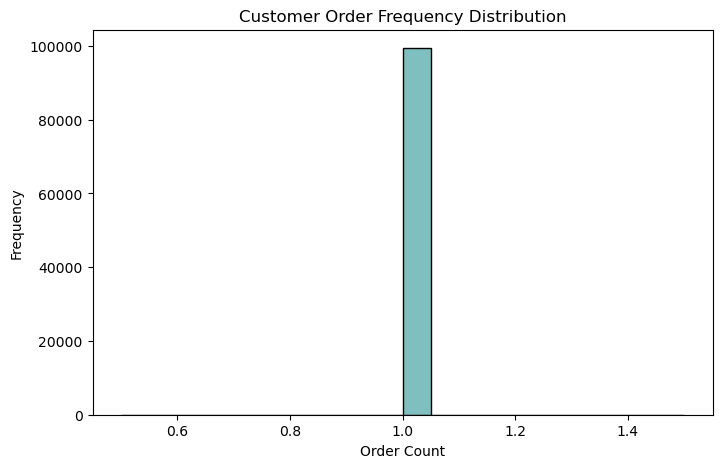

✅ Data visualization completed successfully!


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Enhanced Data
orders = pd.read_csv('enhanced_olist_orders_dataset.csv')
order_items = pd.read_csv('enhanced_olist_order_items_dataset.csv')
order_payments = pd.read_csv('enhanced_olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('enhanced_olist_order_reviews_dataset.csv')
products = pd.read_csv('enhanced_olist_products_dataset.csv')
sellers = pd.read_csv('enhanced_olist_sellers_dataset.csv')
customers = pd.read_csv('enhanced_olist_customers_dataset.csv')

### ✅ 1. Delivery Time Distribution
plt.figure(figsize=(8, 5))
sns.histplot(orders['delivery_time'], bins=30, kde=True, color='skyblue')
plt.title('Delivery Time Distribution (in Days)')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Frequency')
plt.show()

### ✅ 2. Payment Value vs Delivery Time
plt.figure(figsize=(8, 5))
sns.scatterplot(x='payment_value', y='delivery_time', data=orders, alpha=0.5)
plt.title('Payment Value vs Delivery Time')
plt.xlabel('Payment Value')
plt.ylabel('Delivery Time (Days)')
plt.show()

### ✅ 3. Review Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='review_score', data=order_reviews, palette='viridis')
plt.title('Review Score Distribution')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.show()

### ✅ 4. Monthly Order Volume
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
monthly_orders = orders['order_purchase_timestamp'].dt.to_period('M').value_counts().sort_index()
plt.figure(figsize=(12, 6))
monthly_orders.plot(kind='line', marker='o', color='purple')
plt.title('Monthly Order Volume')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid()
plt.show()

### ✅ 5. Price Range by Product Category
plt.figure(figsize=(10, 6))
sns.boxplot(x='price_range', data=products)
plt.title('Price Range by Product Category')
plt.xlabel('Price Range')
plt.show()

### ✅ 6. Seller Performance (Average Review Score)
plt.figure(figsize=(8, 5))
sns.histplot(sellers['avg_seller_review_score'], bins=20, kde=True, color='orange')
plt.title('Seller Performance (Average Review Score)')
plt.xlabel('Average Review Score')
plt.ylabel('Frequency')
plt.show()

### ✅ 7. Most Common Product Categories
top_categories = products['product_category_name_english'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categories.index, y=top_categories.values, palette='magma')
plt.title('Top 10 Most Common Product Categories')
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

### ✅ 8. Order Count by Day of the Week
day_order_count = orders['order_day_of_week'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=day_order_count.index, y=day_order_count.values, palette='coolwarm')
plt.title('Order Count by Day of the Week')
plt.xlabel('Day of the Week (0=Monday)')
plt.ylabel('Order Count')
plt.show()

### ✅ 9. Correlation Heatmap
corr = orders[['delivery_time', 'payment_value', 'payment_ratio', 'review_sentiment']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### ✅ 10. Customer Order Frequency Distribution
plt.figure(figsize=(8, 5))
sns.histplot(customers['order_count'], bins=20, kde=True, color='teal')
plt.title('Customer Order Frequency Distribution')
plt.xlabel('Order Count')
plt.ylabel('Frequency')
plt.show()

print("✅ Data visualization completed successfully!")


In [8]:
# Merge orders with order items and products
data = orders.merge(order_items, on='order_id', how='left')\
             .merge(products, on='product_id', how='left')\
             .merge(order_payments, on='order_id', how='left')\
             .merge(order_reviews, on='order_id', how='left')

# Merge all DataFrames
data = orders.merge(order_items, on='order_id', how='left')\
             .merge(products, on='product_id', how='left')\
             .merge(order_payments, on='order_id', how='left')\
             .merge(order_reviews, on='order_id', how='left')

# Ensure the correct columns are included after merging
print(data.columns)# Keep only one version of payment_value and review_sentiment
data = data.rename(columns={'payment_value_x': 'payment_value', 'review_sentiment_x': 'review_sentiment'})
data.drop(columns=['payment_value_y', 'review_sentiment_y'], inplace=True, errors='ignore')

# Create payment_ratio based on payment_value
data['payment_ratio'] = data['payment_value'] / data['payment_value'].max()

# Create review_sentiment based on review_score
data['review_sentiment'] = data['review_score'].apply(lambda x: 1 if x >= 4 else (0 if x <= 2 else 0.5))


# Keep only one version of payment_value and review_sentiment
data = data.rename(columns={'payment_value_x': 'payment_value', 'review_sentiment_x': 'review_sentiment'})
data.drop(columns=['payment_value_y', 'review_sentiment_y'], inplace=True, errors='ignore')



# Create payment_ratio if missing
data['payment_ratio'] = data['payment_value'] / data['payment_value'].max()

# Create review_sentiment based on review_score
data['review_sentiment'] = data['review_score'].apply(lambda x: 1 if x >= 4 else (0 if x <= 2 else 0.5))

print(data[['payment_value', 'review_sentiment']].head())


features = [
    'payment_value', 'payment_ratio', 'review_sentiment', 
    'price_range', 'product_weight_g', 'product_length_cm', 
    'product_width_cm', 'product_height_cm'
]

target = 'delivery_time'

# Handle missing values
data = data[features + [target]].dropna()


Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'delivery_time', 'payment_value_x', 'item_count', 'payment_ratio',
       'review_sentiment_x', 'order_day_of_week', 'order_month',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'price_range', 'product_category_name_english', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value_y', 'review_id',
       'review_score', 'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'review_sentiment_y'],
      dtype='object')
   payment_value  review_sentimen

In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load all CSV files
os.chdir("C:\\Users\\kusha\\OneDrive\\Desktop\\Kushang's Files\\Intel AI Course\\Week 4 - Dependencies\\Dependencies\\data")
os.getcwd()

# Load all CSV files
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')

"""customers = pd.read_csv('customers.csv')
geolocation = pd.read_csv('geolocation.csv')
order_items = pd.read_csv('order_items.csv')
order_payments = pd.read_csv('order_payments.csv')
order_reviews = pd.read_csv('order_reviews.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
sellers = pd.read_csv('sellers.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')

"""

# ✅ Step 1: MERGE DATASETS
# Merge order_reviews with orders using order_id
df = pd.merge(order_reviews, orders, on='order_id', how='inner')

# Merge with order_items using order_id
df = pd.merge(df, order_items, on='order_id', how='inner')

# Merge with products using product_id
df = pd.merge(df, products, on='product_id', how='inner')

# Merge with customers using customer_id
df = pd.merge(df, customers, on='customer_id', how='inner')

# Merge with sellers using seller_id
df = pd.merge(df, sellers, on='seller_id', how='inner')

# Merge with order_payments using order_id
df = pd.merge(df, order_payments, on='order_id', how='inner')

# ✅ Step 2: HANDLE MISSING VALUES
# Drop columns with more than 50% missing values
df = df.dropna(thresh=len(df) * 0.5, axis=1)

# Fill remaining missing values with appropriate strategies
df['review_score'].fillna(df['review_score'].median(), inplace=True)

# ✅ Step 3: CLEAN DATA
# Drop unnecessary columns (e.g., IDs, timestamps that are not useful)
df.drop(['review_id', 'customer_unique_id', 'order_approved_at', 
         'order_delivered_carrier_date', 'order_delivered_customer_date',
         'order_estimated_delivery_date'], axis=1, inplace=True)

# ✅ Step 4: CONVERT DATA TYPES
# Ensure target column is numeric
df['review_score'] = pd.to_numeric(df['review_score'], errors='coerce')

# ✅ Step 5: ENCODE CATEGORICAL FEATURES
# Convert product_category_name to English using mapping
df = pd.merge(df, category_translation, on='product_category_name', how='left')
df['product_category_name'] = df['product_category_name_english']
df.drop('product_category_name_english', axis=1, inplace=True)

# Label encoding for categorical variables
cat_cols = df.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# ✅ Step 6: SCALE NUMERICAL FEATURES
scaler = StandardScaler()
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = scaler.fit_transform(df[num_cols])

# ✅ Step 7: PREPARE TRAINING DATA
X = df.drop('review_score', axis=1)
y = df['review_score']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 8: HANDLE CLASS IMBALANCE (if applicable)
# from imblearn.over_sampling import SMOTE
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)

# ✅ Step 9: TRAIN MODEL
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ✅ Step 10: PREDICT & EVALUATE MODEL
y_pred = model.predict(X_test)

# Performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")


Mean Squared Error: 0.74
R2 Score: 0.26


In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Assuming y_test and y_pred are already defined
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'R² Score: {r2:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


R² Score: 0.2571
Mean Squared Error (MSE): 0.7412
Mean Absolute Error (MAE): 0.6686
Root Mean Squared Error (RMSE): 0.8609
Mean Absolute Percentage Error (MAPE): 274.35%


In [19]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Example: Generate sample data (replace with your actual data)
np.random.seed(42)
X_train = np.random.rand(100, 3)  # 100 samples, 3 features
y_train = np.random.rand(100)

# 1. Convert to pandas DataFrame and Series
X_train = pd.DataFrame(X_train, columns=['Feature1', 'Feature2', 'Feature3'])
y_train = pd.Series(y_train)

# 2. Handle missing values (if any)
X_train, y_train = X_train.align(y_train.dropna(), join='inner', axis=0)

# 3. Initialize and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict using the model
y_pred = model.predict(X_train)

# 5. Evaluate the model
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

# 6. Display Results
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# 7. (Optional) Coefficients and Intercept
print("\nCoefficients:", model.coef_)
print("Intercept:", model.intercept_)


Mean Squared Error: 0.0849899498269736
R² Score: 0.003086255691568063

Coefficients: [0.05592751 0.00798635 0.00971752]
Intercept: 0.4555644159396626


In [13]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Load all CSV files
path = "C:\\Users\\kusha\\OneDrive\\Desktop\\Kushang's Files\\Intel AI Course\\Week 4 - Dependencies\\Dependencies\\data"
os.chdir(path)

# Load datasets
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')

# Check the data
print(customers.head())
print(geolocation.head())
print(order_items.head())
print(order_payments.head())
print(order_reviews.head())
print(orders.head())
print(products.head())
print(sellers.head())
print(category_translation.head())


                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  
   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                

In [14]:
# Merge data
data = orders.merge(customers, on='customer_id', how='left')
data = data.merge(order_items, on='order_id', how='left')
data = data.merge(order_payments, on='order_id', how='left')
data = data.merge(order_reviews, on='order_id', how='left')
data = data.merge(products, on='product_id', how='left')
data = data.merge(sellers, on='seller_id', how='left')
data = data.merge(category_translation, on='product_category_name', how='left')

# Drop duplicates and unnecessary columns
data.drop(columns=['customer_unique_id', 'order_approved_at', 'order_delivered_carrier_date',
                   'order_delivered_customer_date', 'order_estimated_delivery_date'], inplace=True)

print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119143 non-null  object 
 1   customer_id                    119143 non-null  object 
 2   order_status                   119143 non-null  object 
 3   order_purchase_timestamp       119143 non-null  object 
 4   customer_zip_code_prefix       119143 non-null  int64  
 5   customer_city                  119143 non-null  object 
 6   customer_state                 119143 non-null  object 
 7   order_item_id                  118310 non-null  float64
 8   product_id                     118310 non-null  object 
 9   seller_id                      118310 non-null  object 
 10  shipping_limit_date            118310 non-null  object 
 11  price                          118310 non-null  float64
 12  freight_value                 

In [15]:
# Fill missing values with appropriate strategy
data.fillna({'review_score': data['review_score'].mean(), 
             'payment_value': data['payment_value'].mean(),
             'product_weight_g': data['product_weight_g'].mean(),
             'product_length_cm': data['product_length_cm'].mean(),
             'product_height_cm': data['product_height_cm'].mean(),
             'product_width_cm': data['product_width_cm'].mean()}, inplace=True)

# Encode categorical columns
label_encoder = LabelEncoder()
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Verify processed data
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119143 non-null  int32  
 1   customer_id                    119143 non-null  int32  
 2   order_status                   119143 non-null  int32  
 3   order_purchase_timestamp       119143 non-null  int32  
 4   customer_zip_code_prefix       119143 non-null  int64  
 5   customer_city                  119143 non-null  int32  
 6   customer_state                 119143 non-null  int32  
 7   order_item_id                  118310 non-null  float64
 8   product_id                     119143 non-null  int32  
 9   seller_id                      119143 non-null  int32  
 10  shipping_limit_date            119143 non-null  int32  
 11  price                          118310 non-null  float64
 12  freight_value                 

In [16]:
# Define input and target variables
X = data.drop('payment_value', axis=1)  # Predicting payment value
y = data['payment_value']

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (95314, 34), Test set size: (23829, 34)


In [17]:
# Train Decision Tree
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

# Predict and Evaluate
dt_preds = dt_model.predict(X_test)
dt_rmse = mean_squared_error(y_test, dt_preds, squared=False)
dt_r2 = r2_score(y_test, dt_preds)

print(f"📌 Decision Tree RMSE: {dt_rmse:.2f}")
print(f"📌 Decision Tree R² Score: {dt_r2:.2f}")


📌 Decision Tree RMSE: 157.69
📌 Decision Tree R² Score: 0.59


C:\Users\kusha\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and Evaluate
xgb_preds = xgb_model.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)
xgb_r2 = r2_score(y_test, xgb_preds)

print(f"📌 XGBoost RMSE: {xgb_rmse:.2f}")
print(f"📌 XGBoost R² Score: {xgb_r2:.2f}")


📌 XGBoost RMSE: 103.65
📌 XGBoost R² Score: 0.82


C:\Users\kusha\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
